<a href="https://colab.research.google.com/github/shin0105/4YP/blob/main/car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [ ]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [ ]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [ ]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [ ]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (2, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [ ]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=100)
  #maximum accuracy score
  acc_max=optimizer.fx_opt
  #best parameters
  params_best=optimizer.x_opt
  print(acc_max)
  print(params_best)
  optimizer.plot_convergence()
  optimizer.plot_acquisition()

-0.9834573002754821
[  4.24675947 183.02549311]


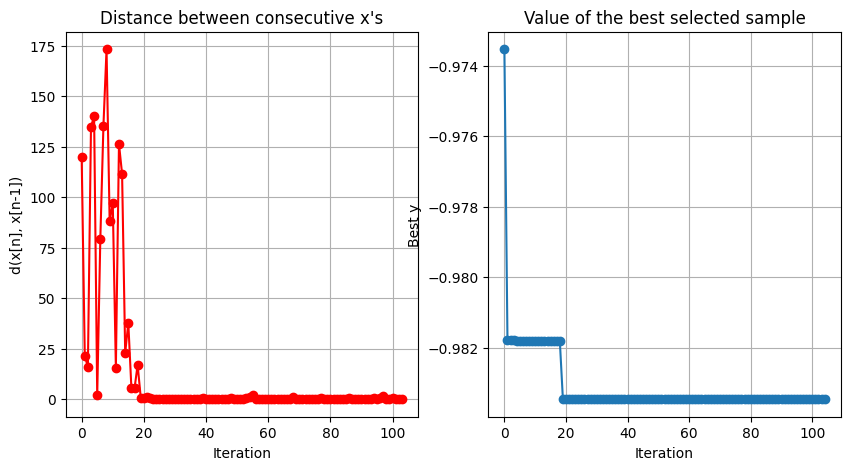

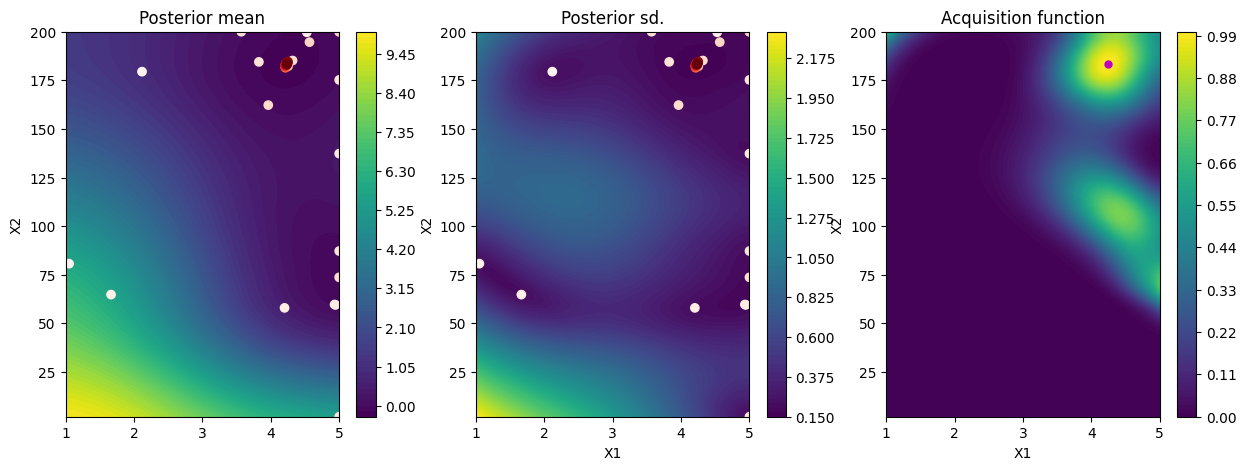

In [ ]:
#RF Classification - Matern52 kernel
kernelM = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(rf_score,kernelM)

In [ ]:
meanacc=[]
for i in range(5):
  rf_car = RandomForestClassifier(max_features=4,n_estimators=183)
  rf_car.fit(X_train,y_train)
  y_pred = rf_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9691714836223507
0.9653179190751445
0.9672447013487476
0.9672447013487476
0.9672447013487476
mean accuracy 0.9672447013487476


-0.9826308539944902
[ 4.06749237 79.35265763]


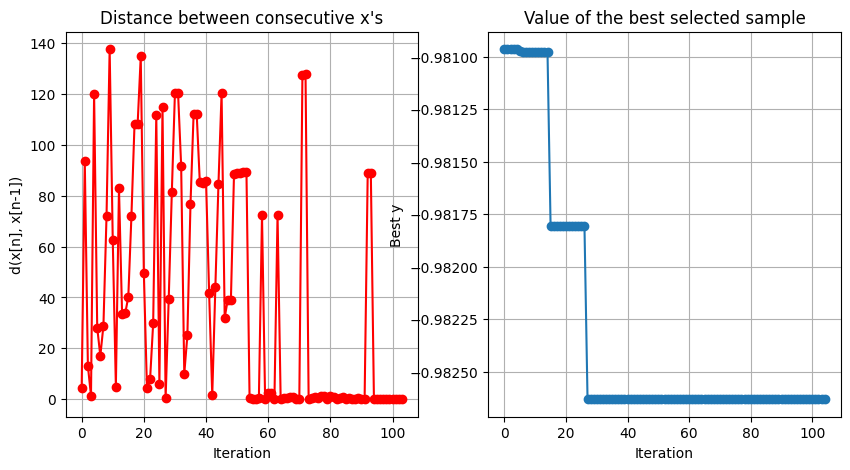

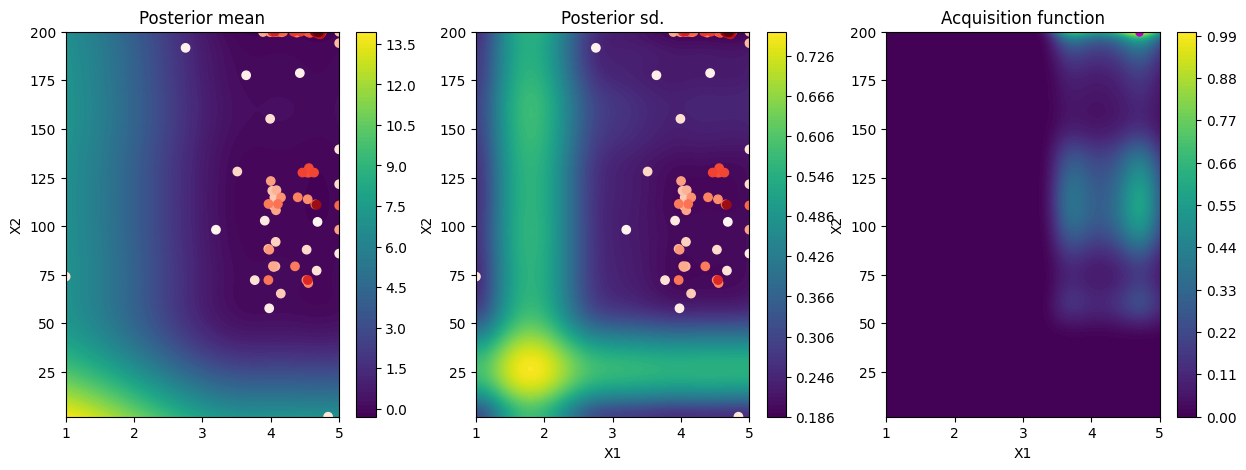

In [ ]:
#RF Classification - Custom kernel
kernel1 = GPy.kern.Matern52(input_dim=1,variance=0.44,lengthscale=18,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1.66e-12,lengthscale=5.43,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=9.696,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=56.74,active_dims=[1])
kernelR = kernel1 + kernel2 + kernel3
BO(rf_score,kernelR)

In [ ]:
meanacc=[]
for i in range(5):
  rf_car = RandomForestClassifier(max_features=4,n_estimators=79)
  rf_car.fit(X_train,y_train)
  y_pred = rf_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9653179190751445
0.9691714836223507
0.9672447013487476
0.9691714836223507
0.9749518304431599
mean accuracy 0.9691714836223507


In [ ]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma': parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.9900826446280993
[30.9750395   0.31446677]


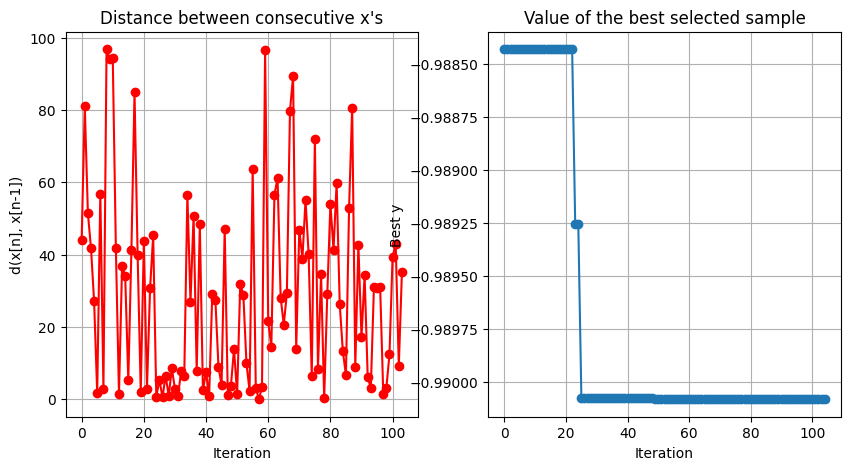

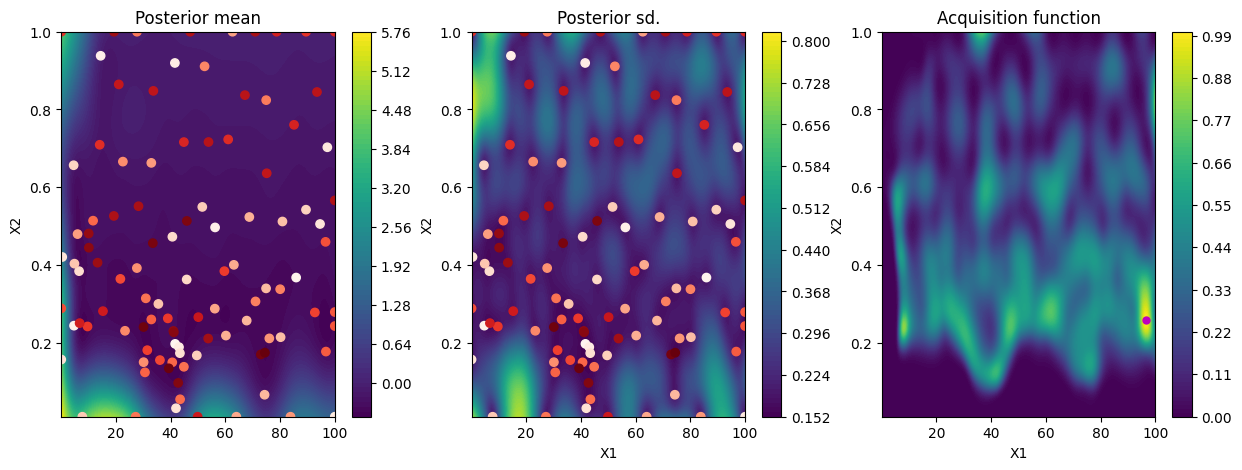

In [ ]:
#SVM Classification - Matern52 kernel
kernel1 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(svm_score,kernel1)

In [ ]:
meanacc=[]
for i in range(5):
  svm_car = svm.SVC(C=30.9750395,gamma=0.31446677)
  svm_car.fit(X_train,y_train)
  y_pred = svm_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9845857418111753
0.9845857418111753
0.9845857418111753
0.9845857418111753
0.9845857418111753
mean accuracy 0.9845857418111754


-0.9900826446280993
[48.40590395  0.31718023]


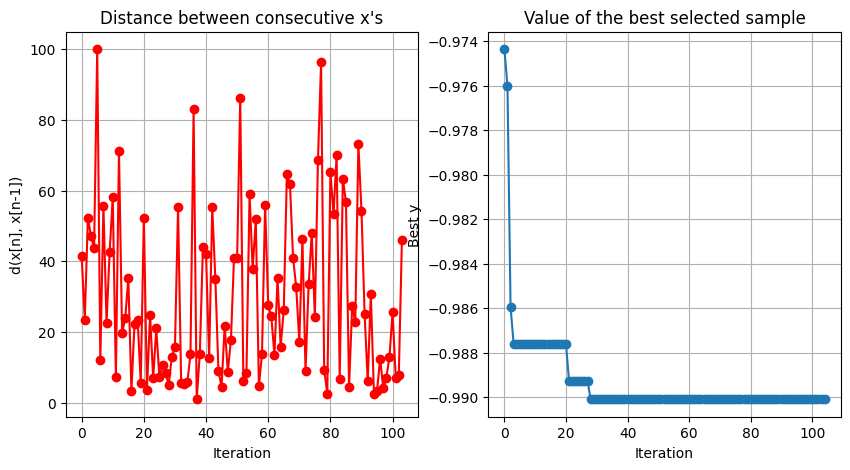

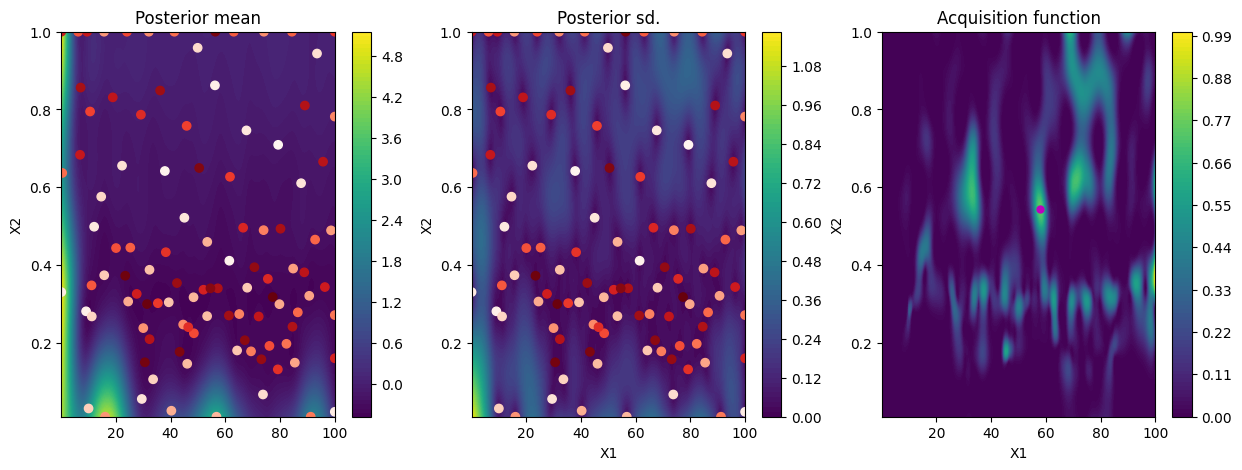

In [ ]:
#SVM Classification - Custom kernel
kernelS = GPy.kern.Matern52(input_dim=1, variance=0.75558	, lengthscale=5.528,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=0.75558, lengthscale=0.4553,active_dims=[1])
BO(svm_score,kernelS)

In [ ]:
meanacc=[]
for i in range(5):
  svm_car = svm.SVC(C=48.40590395,gamma=0.31718023)
  svm_car.fit(X_train,y_train)
  y_pred = svm_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9845857418111753
0.9845857418111753
0.9845857418111753
0.9845857418111753
0.9845857418111753
mean accuracy 0.9845857418111754


In [ ]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': int(parameters[0][0]),
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.9082231404958676
[100.   7.]


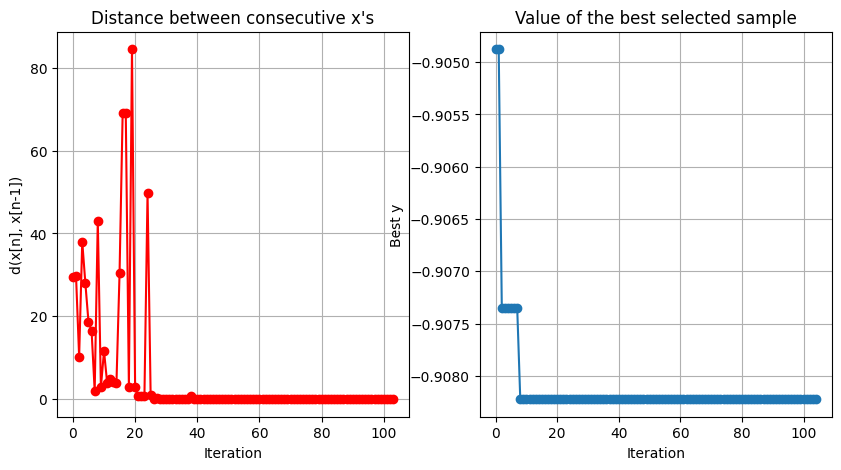

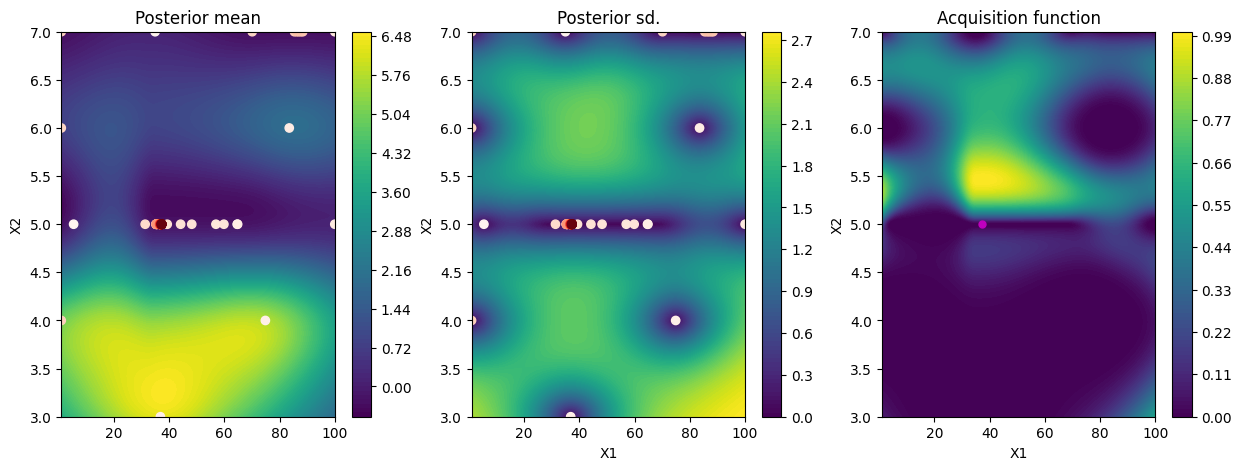

In [ ]:
#KNN Classification - Matern52 kernel
kernelK = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(knn_score,kernelK)

In [ ]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=100,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9267822736030829
0.9267822736030829
0.9267822736030829
0.9267822736030829
0.9267822736030829
mean accuracy 0.9267822736030829


-0.9082231404958676
[73.12340646  7.        ]


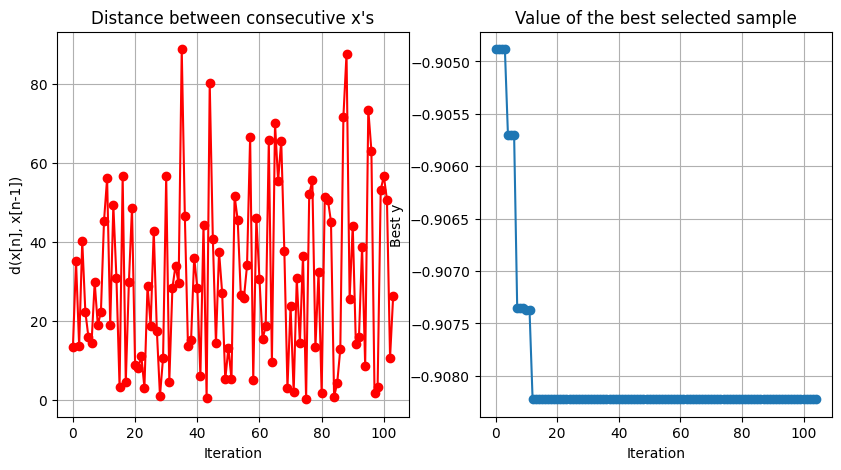

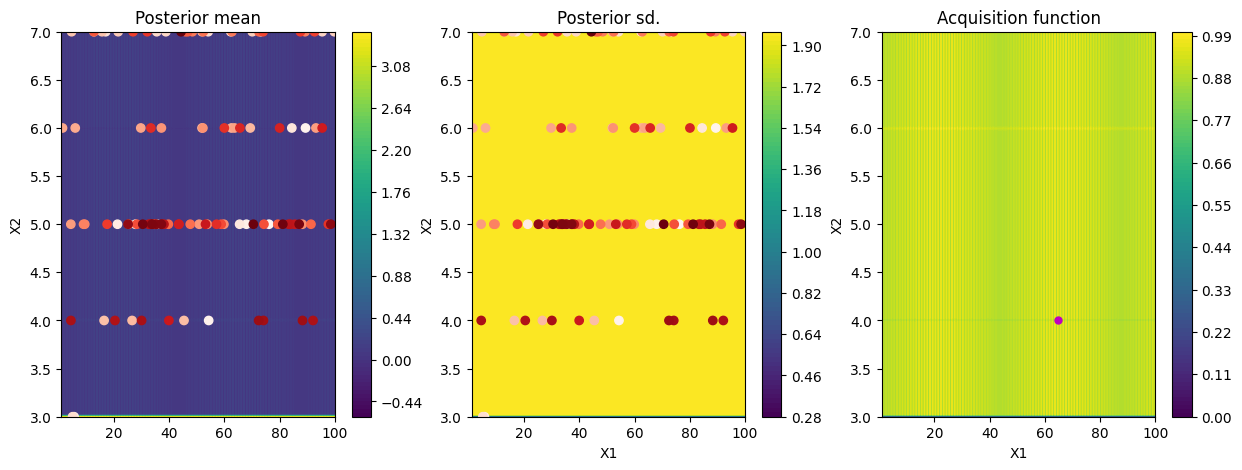

In [ ]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=9.31e-09,lengthscale=71.5,active_dims=[0],period=13)
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.3117,lengthscale=1.67,active_dims=[1],period=2)
kernelK = kernel1 + kernel2
BO(knn_score,kernelK)

-0.9082231404958676
[95.31704131  7.        ]


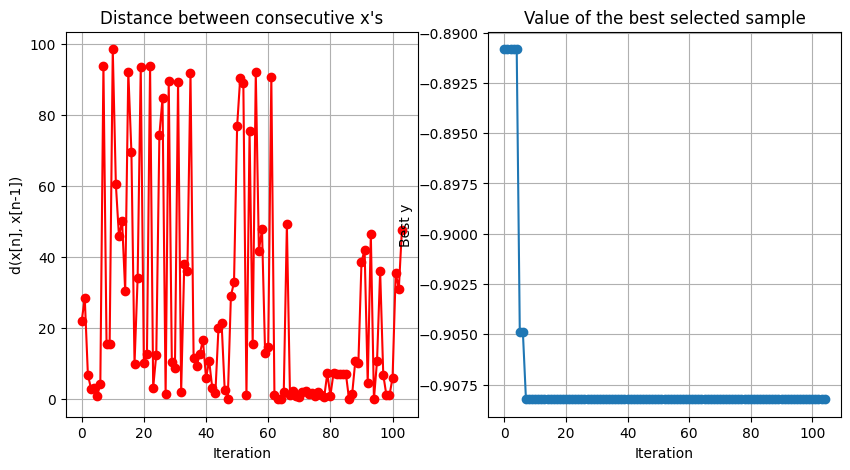

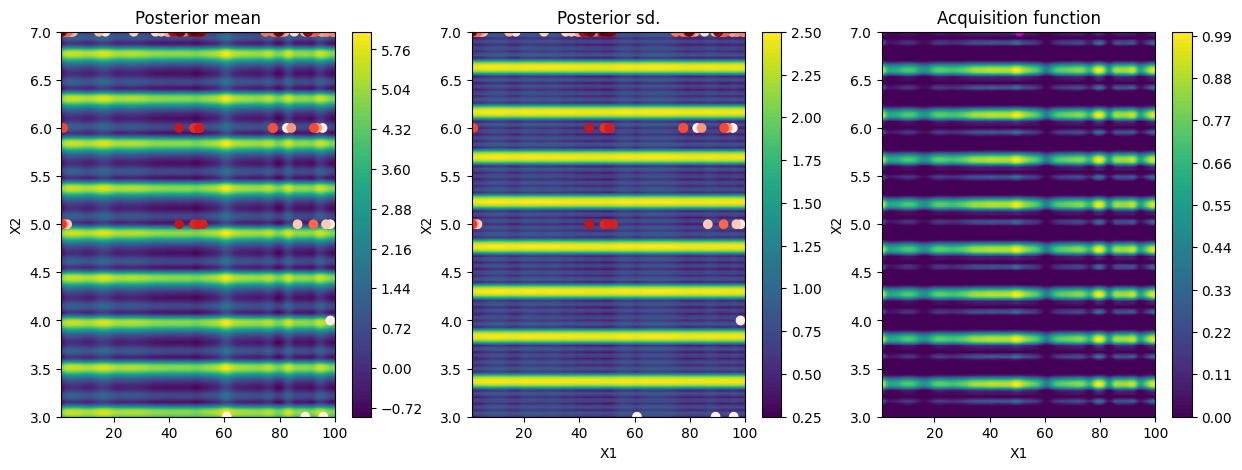

In [ ]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=4.372e-14	,lengthscale=1.00,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,variance = 4.372e-14,lengthscale=1.018,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.3117,lengthscale=1.789,active_dims=[1],period=2)
kernelK = kernel1 + kernel2
BO(knn_score,kernelK)

In [ ]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=95,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.9267822736030829
0.9267822736030829
0.9267822736030829
0.9267822736030829
0.9267822736030829
mean accuracy 0.9267822736030829


In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=0.44,lengthscale=18,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1.66e-12,lengthscale=5.43,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=9.696,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=56.74,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)
optimizer.model.model

GP_regression.,value,constraints,priors
sum.Mat52.variance,3.0768224225204926e-07,+ve,
sum.Mat52.lengthscale,2.181650122716761,+ve,
sum.Mat52_1.variance,0.48942202849846156,+ve,
sum.Mat52_1.lengthscale,1.7604128381333393,+ve,
sum.mul.Mat52.variance,0.6432774544195446,+ve,
sum.mul.Mat52.lengthscale,8.805014752340853e-05,+ve,
sum.mul.Mat52_1.variance,1.0722890312236328,+ve,
sum.mul.Mat52_1.lengthscale,0.1931540494882712,+ve,
Gaussian_noise.variance,0.037182304204739884,"1e-09,1000000.0",


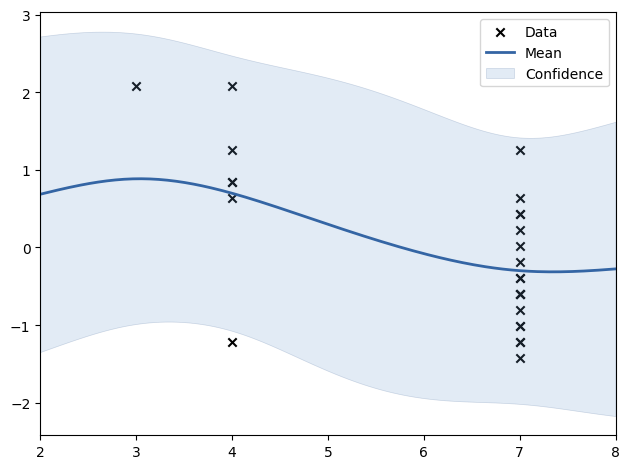

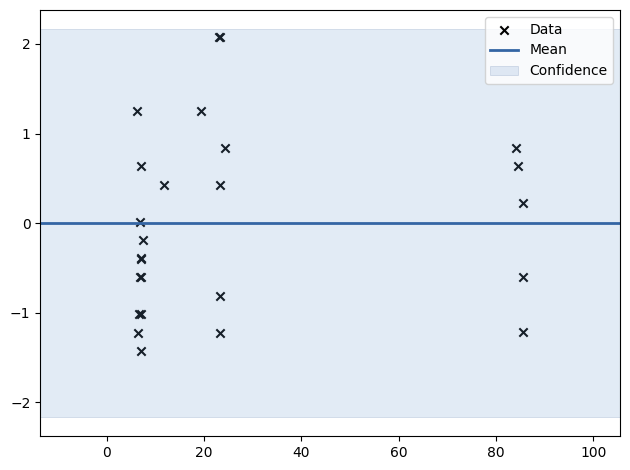

In [ ]:
_ = optimizer.model.model.plot(fixed_inputs=[(0, 1)])
_ = optimizer.model.model.plot(fixed_inputs=[(1, 100)])   

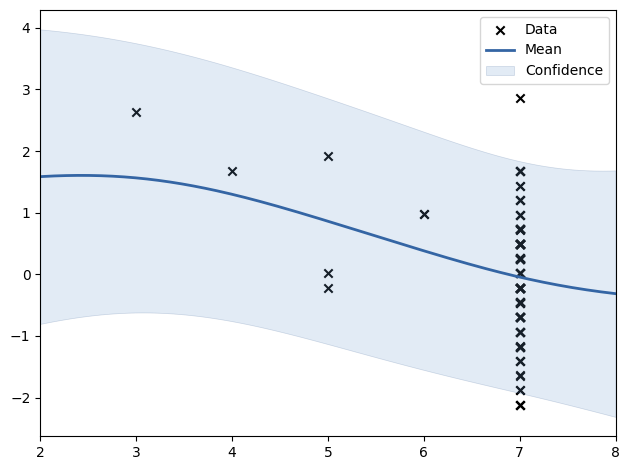

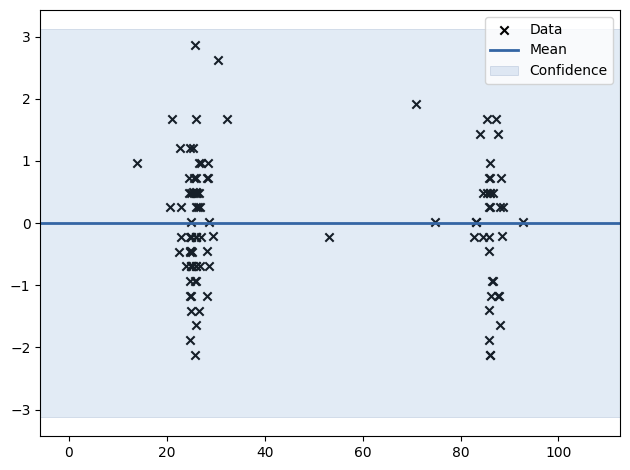

In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=0.44,lengthscale=18,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1.66e-12,lengthscale=5.43,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=9.696,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=56.74,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=100)
optimizer.model.model
_ = optimizer.model.model.plot(fixed_inputs=[(0, 1)])
_ = optimizer.model.model.plot(fixed_inputs=[(1, 100)])   

In [29]:
optimizer.model.model

GP_regression.,value,constraints,priors
sum.Mat52.variance,0.2673233227527229,+ve,
sum.Mat52.lengthscale,3.743973063181463e-05,+ve,
sum.Mat52_1.variance,1.6186984452732898,+ve,
sum.Mat52_1.lengthscale,3.8250776406487352,+ve,
sum.mul.Mat52.variance,4.571803069358718e-06,+ve,
sum.mul.Mat52.lengthscale,0.35443295131317215,+ve,
sum.mul.Mat52_1.variance,4.56429134205115e-06,+ve,
sum.mul.Mat52_1.lengthscale,1.207020474861846,+ve,
Gaussian_noise.variance,0.643449237879821,"1e-09,1000000.0",


In [30]:
kernel = GPy.kern.Matern52(input_dim=1, variance=0.75558	, lengthscale=5.528,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=0.75558, lengthscale=0.4553,active_dims=[1])
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=100)
optimizer.model.model

GP_regression.,value,constraints,priors
mul.Mat52.variance,2.0662281793744822e-06,+ve,
mul.Mat52.lengthscale,67516754.98996572,+ve,
mul.Mat52_1.variance,482829.14179446216,+ve,
mul.Mat52_1.lengthscale,22273645.22210194,+ve,
Gaussian_noise.variance,1.0000004034049488e-09,"1e-09,1000000.0",


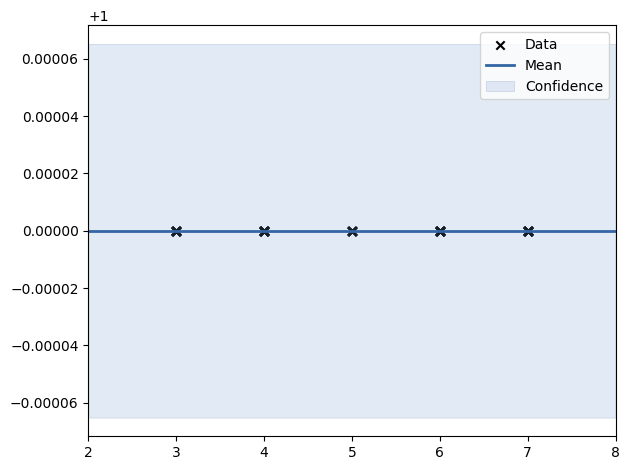

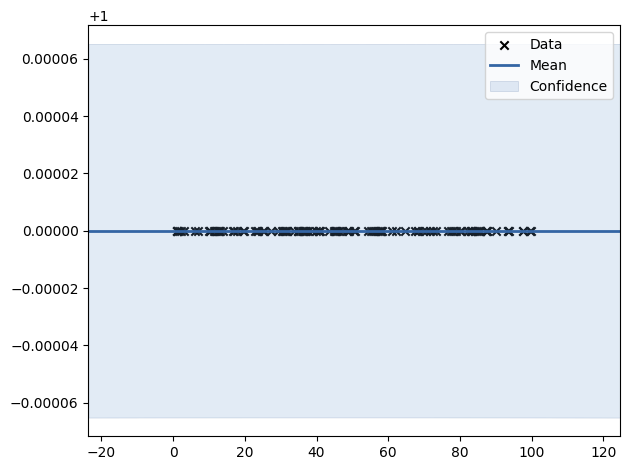

In [31]:
_ = optimizer.model.model.plot(fixed_inputs=[(0, 1)])
_ = optimizer.model.model.plot(fixed_inputs=[(1, 1)])  